# Предсказание стоимости автомобиля на вторичном рынке

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи. Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили.

В рамках данного проекта было принято участие соревновании Kaggle - Used car's price prediction, в рамках которого была проделана работа с данными о продажах автомобилей на вторичном рынке. Целью данного проекта является разработанная модель предсказания стоимости автомобиля на вторичном рынке.

В ходе работы были пройдены все основные этапы полноценного исследования:
- загрузка и ознакомление с данными,
- предварительная обработка,
- разведочный анализ и разработка новых синтетических признаков,
- отбор финального набора обучающих признаков,
- выбор и обучение модели,
- анализ важности ее признаков.

Входные данные:
- `train.csv` - информация о продажах (~440000) автомобилей с аукционов, которые будут использоваться в качестве обучающих данных.
- `test.csv` - информация о продажах (~110000) автомобилей с аукционов, которые будут использоваться в качестве тестовых данных. 

Задача для будущей модели - предсказать значение `sellingprice` для каждого автомобиля из этого датасета.

Результатом будет файл формата CSV с `vin` из файла `test.csv` и предсказанием числового значения стоимости автомобиля `sellingprice`.

### Описание полей данных
- `year` - год производства
- `make` - производитель
- `model` - модель
- `trim` - модификация
- `body` - тип кузова
- `transmission` - тип КПП
- `vin` - идентификатор (вин)
- `state` - штат регистрации
- `condition` - состояние по шкале (1-5)
- `odometer` - пробег в милях
- `color` - цвет кузова
- `interior` - цвет интерьера
- `seller` - продавец
- `saledate` - дата продажи

Ключевой признак:
- `sellingprice` - стоимость продажи

### 1. Загрузка и ознакомление с данными

Для начала работы объявим все необходимые нам библиотеки, загрузим датасеты и выведем их содержимое на экран.
Поскольку библиотека catboost не является предустановленной, загрузим ее.

In [1]:
! pip install catboost

In [2]:
from catboost import CatBoostRegressor
from catboost import cv, Pool
import category_encoders as ce
import pandas as pd
import pylab
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

In [4]:
df_train.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


In [5]:
df_test.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)


### 2. Предварительная обработка

Имеющиеся датасеты имеют одинаковую структуру, но в дальнейшем будут исапользоваться нами для разных целей: `df_train` для обучения модели, `df_test` для тестирования обученной модели.
Посмотрим на информацию, хранящуюся в детесете.

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


У обоих датасетов признаки имеют подходящий формат данных, смена формата не требуется.
Проверим тренировочный датасет на полные дупликаты.

In [8]:
df_train.duplicated().sum()

0

Полные дупликаты отсутствуют.

Проведем проверку тренировочного датасета на пропущенные значения. Для этого посмотрим список признаков и процент пропусков по каждому.

In [9]:
df_train.isna().mean().sort_values(ascending=False)

transmission    0.116894
body            0.023608
condition       0.021364
trim            0.018938
model           0.018451
make            0.018270
color           0.001331
interior        0.001331
odometer        0.000157
year            0.000000
vin             0.000000
state           0.000000
seller          0.000000
sellingprice    0.000000
saledate        0.000000
dtype: float64

In [10]:
cat_features = list(df_train.select_dtypes(include='object').columns)
cat_features

['make',
 'model',
 'trim',
 'body',
 'transmission',
 'vin',
 'state',
 'color',
 'interior',
 'seller',
 'saledate']

Такие значения как `condition` и `odometer` имеют `2.1%` и `0.01%` пропусков соответственно, однако они являются чиловыми и будут обработаны выбранной в дальнейшем моделью автоматически. Остальные колонки имеют небольшой процент пропусков. На даном этапе мы могли бы избавиться от таких строк с пропусками, таким образом кросс-валидация покажет лучшие результаты. Однако, опытным путем мы выснили, что в конечном итоге такая манипуляция влияет на метрику по результатам тестовой выборки в худшую сторону. Поэтому мы заполним пропущенные значения `no_info`.

In [11]:
df_train[cat_features] = df_train[cat_features].fillna('no_info')
df_test[cat_features] = df_test[cat_features].fillna('no_info')

In [12]:
df_train.isna().mean().sort_values(ascending=False)

condition       0.021364
odometer        0.000157
year            0.000000
make            0.000000
model           0.000000
trim            0.000000
body            0.000000
transmission    0.000000
vin             0.000000
state           0.000000
color           0.000000
interior        0.000000
seller          0.000000
sellingprice    0.000000
saledate        0.000000
dtype: float64

Проверим значения `sellingprice` на аномально низкие.

In [13]:
df = df_train[df_train['sellingprice']<100]
df

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
137962,2003,Mercedes-Benz,E-Class,E500,Sedan,automatic,wdbuf70j73a269529,ga,2.1,1.0,black,black,peoples credit company inc,1,Tue Jan 06 2015 09:30:00 GMT-0800 (PST)
418021,2002,Ford,F-350 Super Duty,XLT,Crew Cab,no_info,1ftsw31f52ed16477,ca,2.0,NaN,white,gray,laa leasing,1,Thu Feb 05 2015 04:00:00 GMT-0800 (PST)


Тренировочный датасет имеет небольшое количество таких записей, мы можем от них избавиться без ущерба для дальнейшего обучения модели.

In [14]:
print(df_train['condition'].sort_values().unique())

[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7
 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5
 4.6 4.7 4.8 4.9 5.  nan]


In [15]:
df_train = df_train[df_train['sellingprice']>100]

### 3. Разведочный анализ и разработка новых синтетических признаков

Тренировочный датасет имеет признак `saledate`, который не принесет пользы для последующего обучения. Однако мы можем получить новые признаки: `saledate_year` - год продажи, `saledate_month` - месяц продажи, `age` - возраст автомобиля (как разницу между годом производства и годом продажи.

In [16]:
df_train['saledate_year'] = pd.DatetimeIndex(pd.to_datetime(df_train['saledate'].str[0:15], format='%a %b %d %Y')).year
df_train['age'] = df_train['saledate_year'] - df_train['year']
df_train['saledate_month'] = pd.DatetimeIndex(pd.to_datetime(df_train['saledate'].str[0:15], format='%a %b %d %Y')).month
df_train.head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,age,saledate_month
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT),2015,4,6
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST),2015,1,2
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT),2015,3,6
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT),2015,12,6
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST),2015,8,2


Для дальнейшей обработки приведем все объектные признаки к нижнему регистру.

In [17]:
def str_lower(column, df):
    df[column] = df[column].str.lower()

for column in cat_features:
    str_lower(column, df_train)
    str_lower(column, df_test)
    
df_train.head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,age,saledate_month
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,tue jun 02 2015 02:30:00 gmt-0700 (pdt),2015,4,6
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,wed feb 25 2015 02:00:00 gmt-0800 (pst),2015,1,2
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,wed jun 10 2015 02:30:00 gmt-0700 (pdt),2015,3,6
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,wed jun 17 2015 03:00:00 gmt-0700 (pdt),2015,12,6
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,tue feb 03 2015 04:00:00 gmt-0800 (pst),2015,8,2


Признак `vin_manufacturer` содержит уникальный идентификационный номер автомобиля. Первые 3 символа показывают страну и завод провзводства. Мы не можем использовать ВИН-номер для обучения, поскольку он уникален, но можем использовать первые 3 символа для улучшения качества нашей модели.

In [18]:
df_train['vin_manufacturer'] = df_train['vin'].str[0:3]
df_train.head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,saledate_year,age,saledate_month,vin_manufacturer
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,tue jun 02 2015 02:30:00 gmt-0700 (pdt),2015,4,6,2fm
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,wed feb 25 2015 02:00:00 gmt-0800 (pst),2015,1,2,3fa
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,wed jun 10 2015 02:30:00 gmt-0700 (pdt),2015,3,6,3n1
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,wed jun 17 2015 03:00:00 gmt-0700 (pdt),2015,12,6,5gr
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,tue feb 03 2015 04:00:00 gmt-0800 (pst),2015,8,2,3fa


Далее посмотрим, какие признаки мы можем перевести в категориальные.

- Код страны производителя

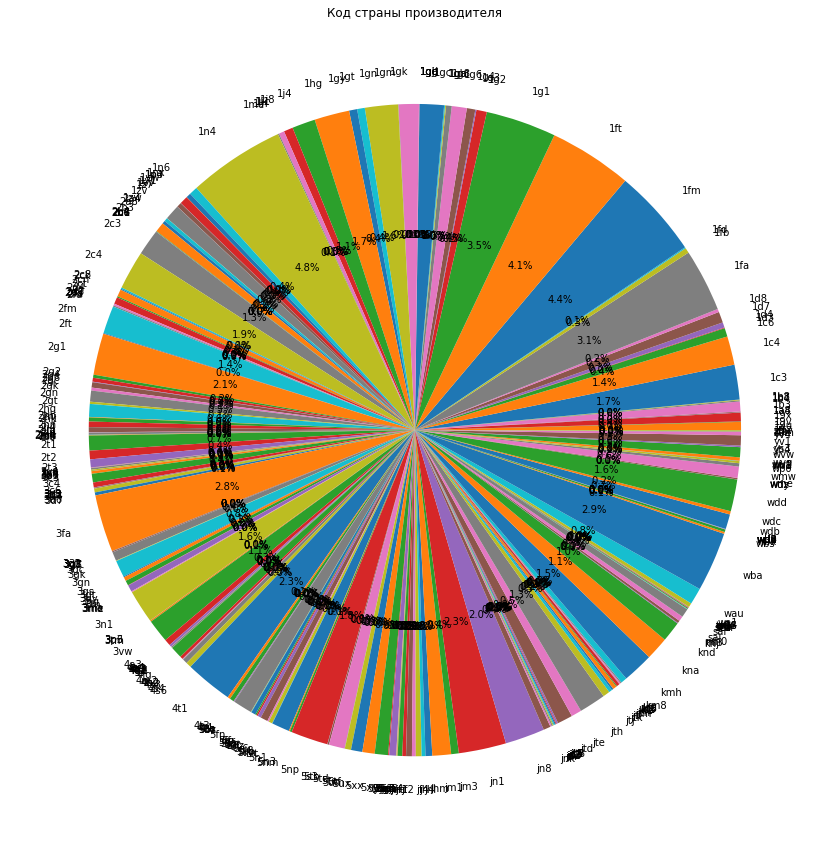

In [19]:
df_group = df_train.groupby('vin_manufacturer')['vin_manufacturer'].count()
df_group.plot(kind='pie', autopct='%1.1f%%', figsize=(15,15))
pylab.title('Код страны производителя')
plt.ylabel('')
pylab.show()

Поскольку мест производства слишком много, создание категориального признака не поможет модели обучиться лучше. Также, если мы возьмем только первый символ ВИН-номера, означающий страну производства, это отрицательно скажется на обучении модели в дальнейшем и даст результат хуже.

- Модификация

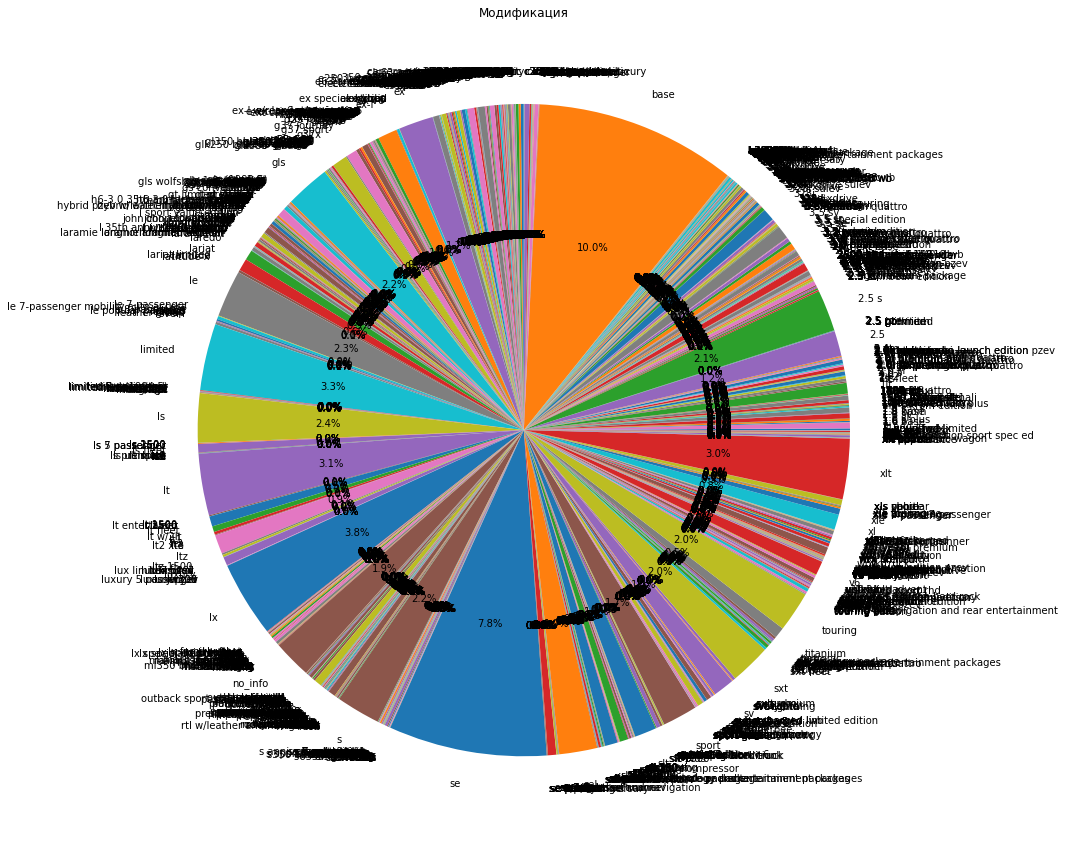

In [20]:
df_group = df_train.groupby('trim')['trim'].count()
df_group.plot(kind='pie', autopct='%1.1f%%', figsize=(15,15))
pylab.title('Модификация')
plt.ylabel('')
pylab.show()

Мы видим, что несмотря на большое количество разнообразных модификаций, мы можем добавить категориальный признак, поместив в него все самые часто всречающиеся модификации, а модификации, которые встречаются редко, поместить в общую группу `Прочие`.

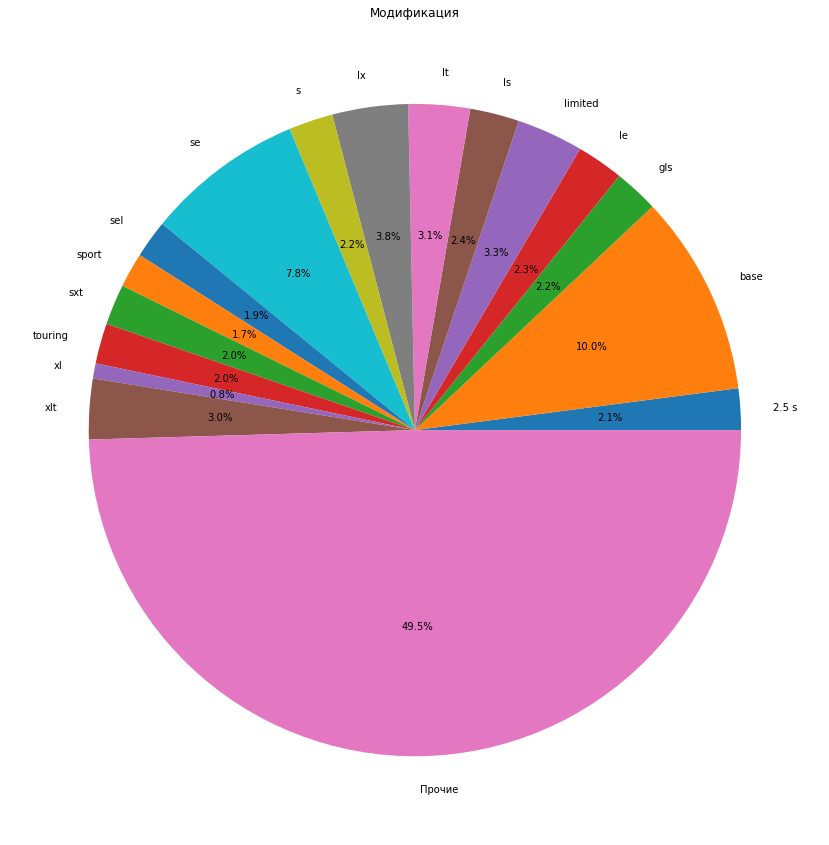

In [21]:
def trim_group(value):
    if value == 'base' or value == 'se' or value == 'limited' or value == 'xl' or value == 'lt' or value == 'ls' or value == 'le' or value == 'gls' or value == '2.5 s' or value == 'xlt' or value == 'touring' or value == 'sport' or value == 'sxt' or value == 'sel' or value == 's' or value == 'lx':
        return value
    else:
        return 'Прочие'
    
df_train['trim_groupped'] = df_train['trim'].apply(trim_group)

df_group = df_train.groupby('trim_groupped')['trim_groupped'].count()
df_group.plot(kind='pie', autopct='%1.1f%%', figsize=(15,15))
pylab.title('Модификация')
plt.ylabel('')
pylab.show()

Да данном этапе группа `Прочие` занимает `49.5%`, это достаточно большой показатель, поэтому группировку можно назвать `грубой`. На этапе обучения модели мы переберем признаки и выберем наиболее подходящие из признаков из датасета и новых признаков.

- Штат регистрации

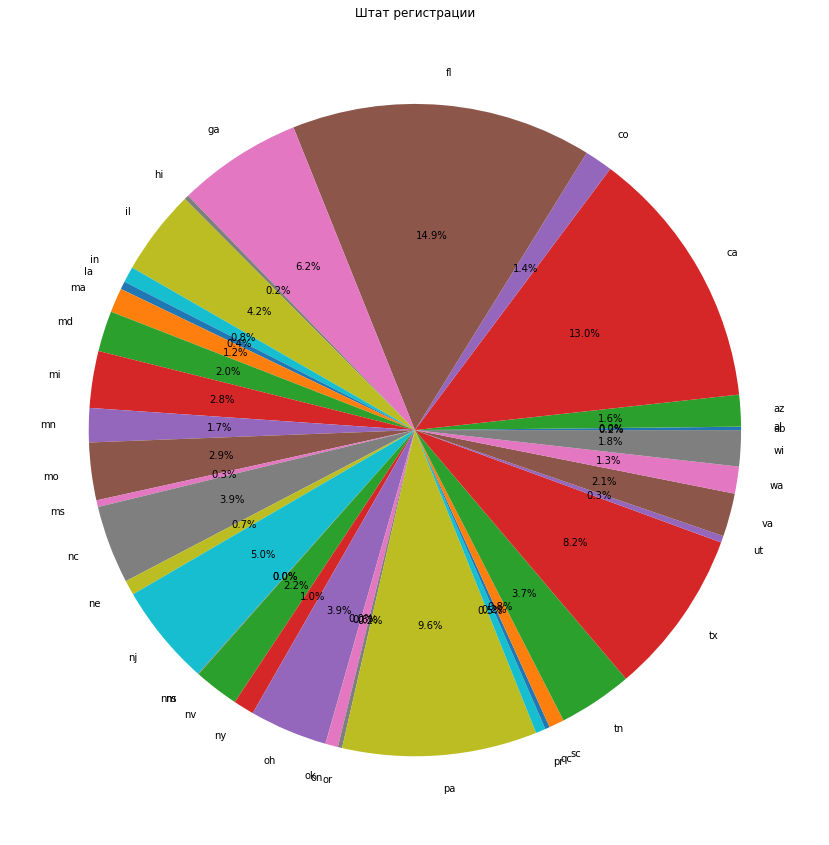

In [22]:
df_group = df_train.groupby('state')['state'].count()
df_group.plot(kind='pie', autopct='%1.1f%%', figsize=(15,15))
pylab.title('Штат регистрации')
plt.ylabel('')
pylab.show()

Самым частым штатом регитсрации являются `fl` - Флорида, `ca` - Калифорния, `pa` - Пенсильвания, `tx` - Техас и `ga` - Джорджия. Суммарно машины из этих штатов составляют более `50%` от всего датасета, остальные штаты составляют до `5%` всей популяции. Создадим категориальный признак `state_groupped`.

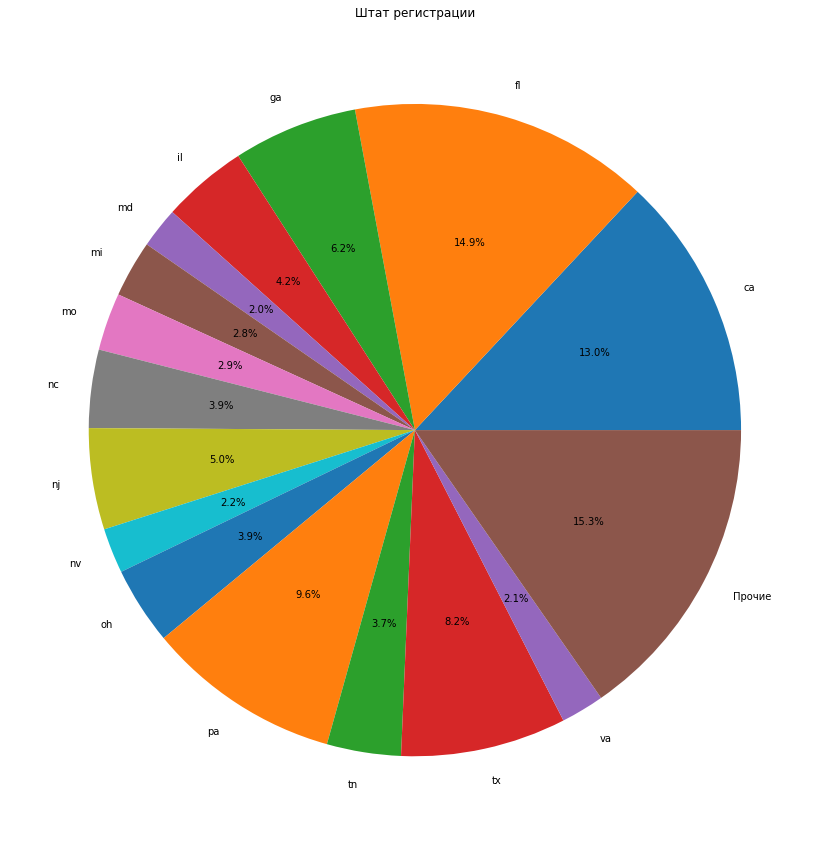

In [23]:
def state_group(value):
    if value == 'fl' or value == 'ca' or value == 'tx' or value == 'tn' or value == 'pa' or value == 'oh' or value == 'nj' or value == 'nc' or value == 'mo' or value == 'mi' or value == 'md' or value == 'il' or value == 'ga' or value == 'va' or value == 'nv':
        return value
    else:
        return 'Прочие'
    
df_train['state_groupped'] = df_train['state'].apply(state_group)

df_group = df_train.groupby('state_groupped')['state_groupped'].count()
df_group.plot(kind='pie', autopct='%1.1f%%', figsize=(15,15))
pylab.title('Штат регистрации')
plt.ylabel('')
pylab.show()

Штаты, попавшие в группу `Прочие` составляют менее `2%` от всей популяции каждый, однако совместно они образуют `15.3%`. В дальнейшем мы проверим, принесет ли пользу новый категориальный признак в обучении модели.

- Цвет кузова

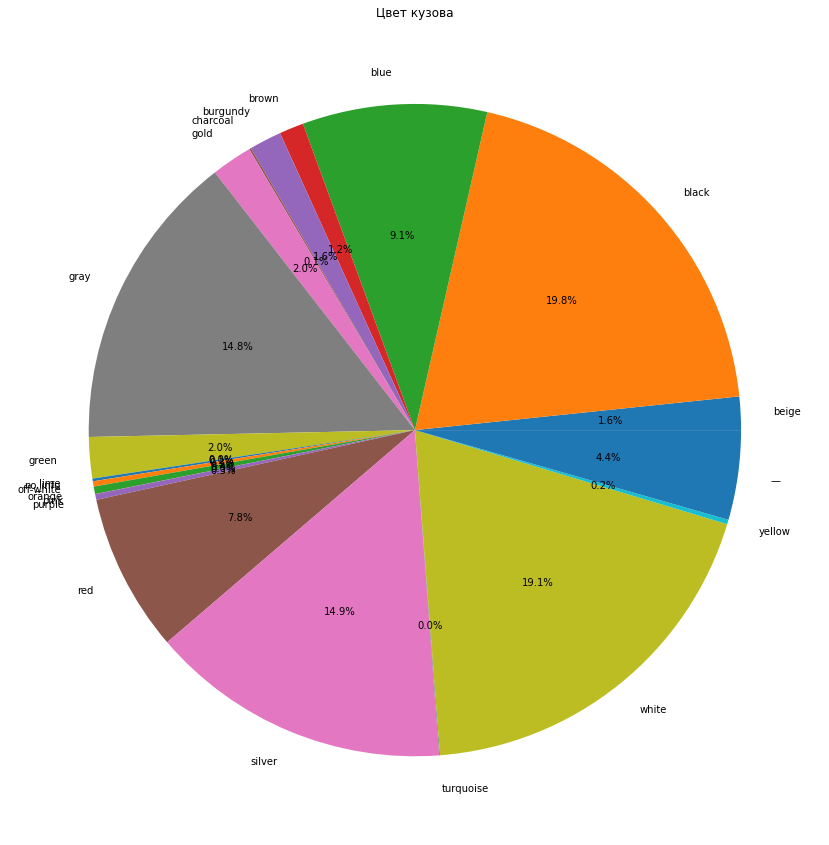

In [24]:
df_group = df_train.groupby('color')['color'].count()
df_group.plot(kind='pie', autopct='%1.1f%%', figsize=(15,15))
pylab.title('Цвет кузова')
plt.ylabel('')
pylab.show()

Мы видим, что `черный`, `белый`, `серебряный` и `серый` цвета кузова составляют наибольшую часть популяции - суммарно более `50%`. Создадим новый категориальный признак `color_groupped`.

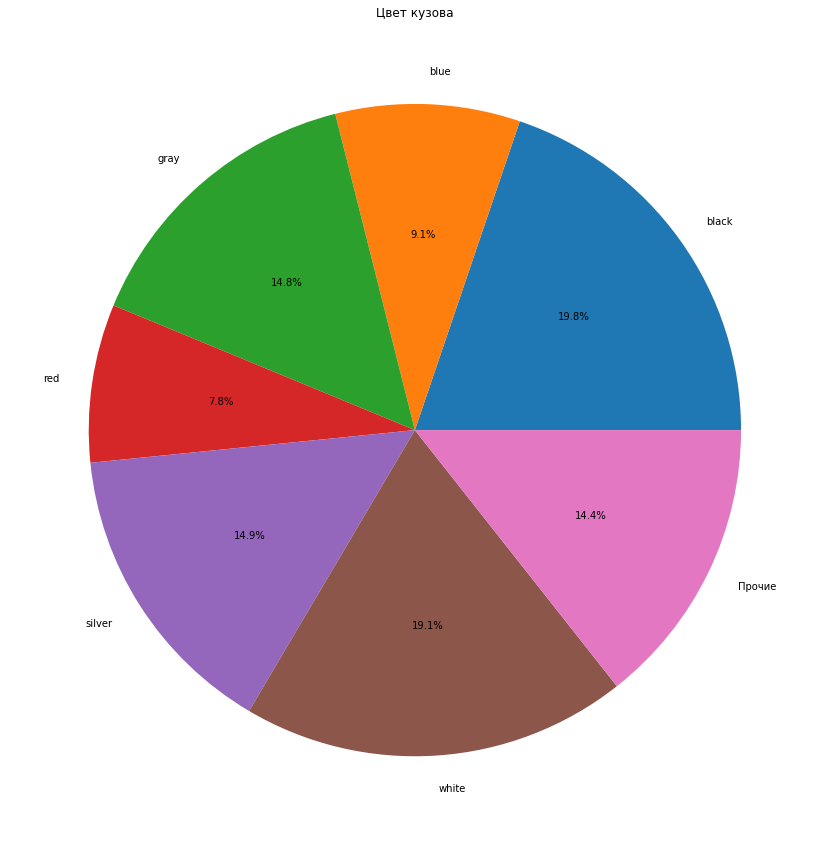

In [25]:
def color_group(value):
    if value == 'blue' or value == 'black' or value == 'white' or value == 'silver' or value == 'red' or value == 'gray':
        return value
    else: 
        return 'Прочие'
    
df_train['color_groupped'] = df_train['color'].apply(color_group)

df_group = df_train.groupby('color_groupped')['color_groupped'].count()
df_group.plot(kind='pie', autopct='%1.1f%%', figsize=(15,15))
pylab.title('Цвет кузова')
plt.ylabel('')
pylab.show()

Группа `Прочие` составила `14.4%`. Это достаточно большой показатель для обобщения, однако основные цвета кузова выделены.

- Цвет интерьера

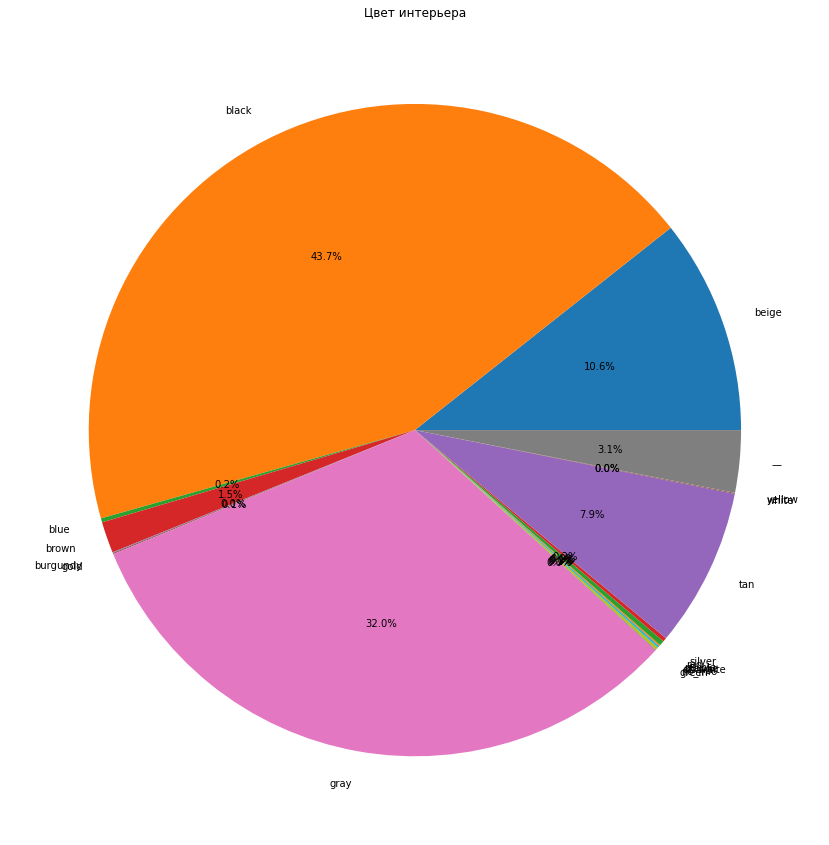

In [26]:
df_group = df_train.groupby('interior')['interior'].count()
df_group.plot(kind='pie', autopct='%1.1f%%', figsize=(15,15))
pylab.title('Цвет интерьера')
plt.ylabel('')
pylab.show()

Цвета интерьера автомобилей обучающего датасета представлены менее разнообразны: наиболее частым цветом является `черный` или `серый`, их общая совокупность составляет `75.7%` от всего датасета. Добавим категориальный признак по цветам интерьера, которые имеют более `5%` популяции.

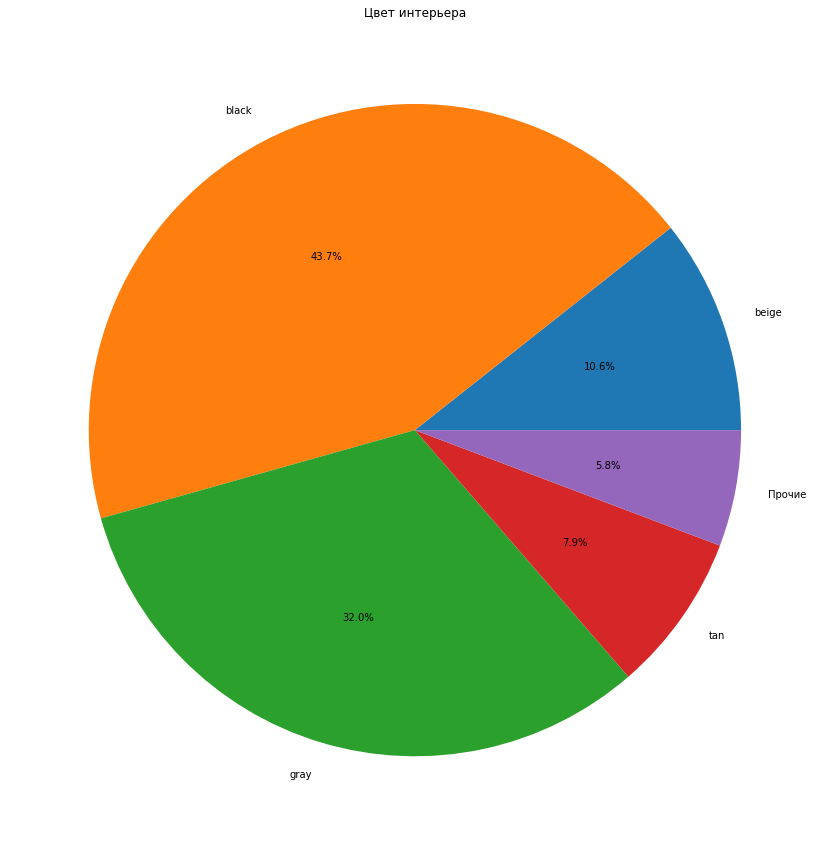

In [27]:
def interior_group(value):
    if value == 'beige' or value == 'black' or value == 'gray' or value == 'tan':
        return value
    else:
        return 'Прочие' 
    
df_train['interior_groupped'] = df_train['interior'].apply(interior_group)

df_group = df_train.groupby('interior_groupped')['interior_groupped'].count()
df_group.plot(kind='pie', autopct='%1.1f%%', figsize=(15,15))
pylab.title('Цвет интерьера')
plt.ylabel('')
pylab.show()

В целом группа `Прочие` составляет не более `6%` от всей популяции, это достаточно низкий показатель, с учетом количества цветов в группе. Таким образом мы можем избавить модель от `шума` и помочь ей обучиться более качественно.

- Тип кузова

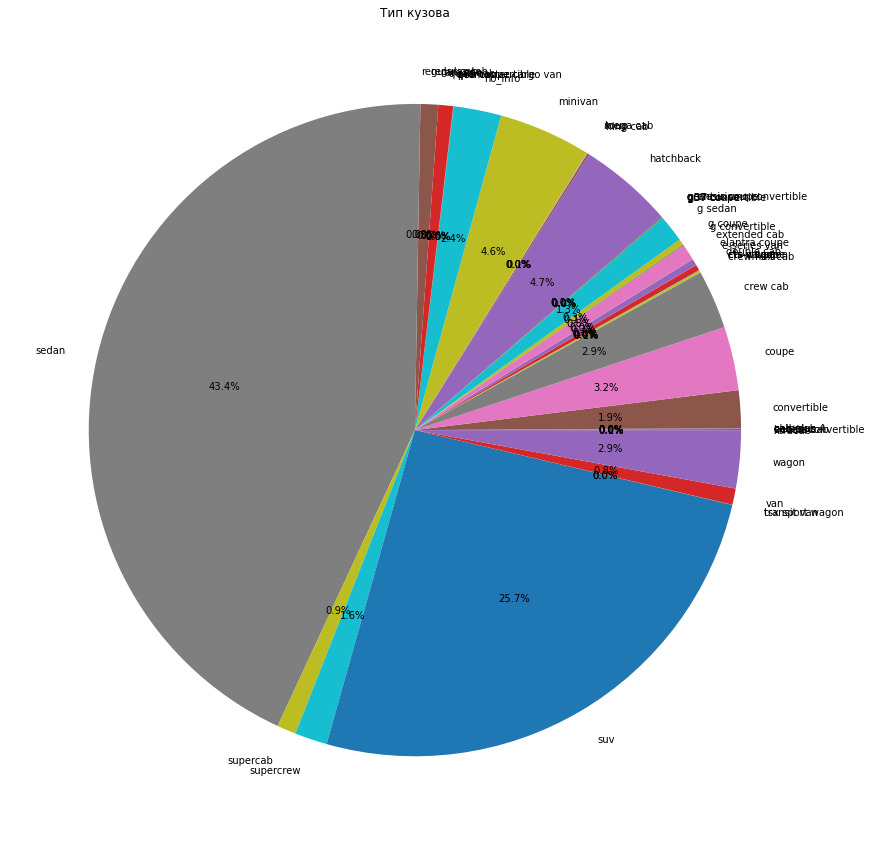

In [28]:
df_group = df_train.groupby('body')['body'].count()
df_group.plot(kind='pie', autopct='%1.1f%%', figsize=(15,15))
pylab.title('Тип кузова')
plt.ylabel('')
pylab.show()

В целом, наибольшую часть популяции составляют `Sedan` и `SUV`, общий процент более `69%`. Добавим новый признак с группировкой для дальнейших экспериментов.

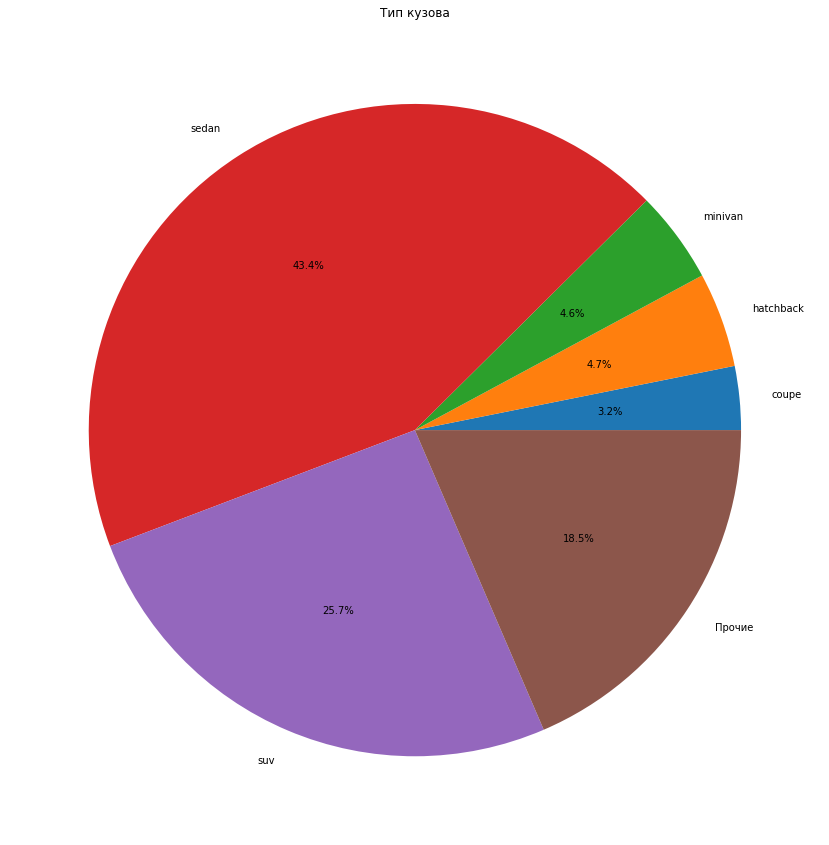

In [29]:
def body_group(value):
    if value == 'sedan' or value == 'suv' or value == 'hatchback' or value == 'minivan' or value == 'coupe':
        return value
    else:
        return 'Прочие' 
    
df_train['body_groupped'] = df_train['body'].apply(body_group)

df_group = df_train.groupby('body_groupped')['body_groupped'].count()
df_group.plot(kind='pie', autopct='%1.1f%%', figsize=(15,15))
pylab.title('Тип кузова')
plt.ylabel('')
pylab.show()

- Модель

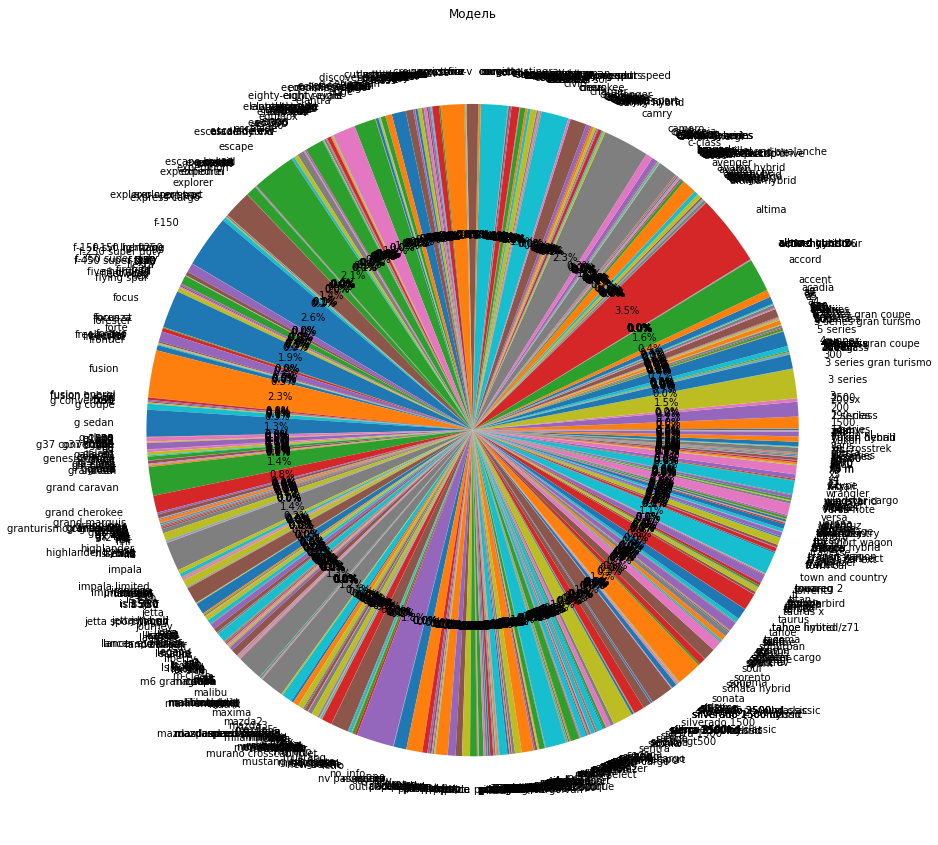

In [30]:
df_group = df_train.groupby('model')['model'].count()
df_group.plot(kind='pie', autopct='%1.1f%%', figsize=(15,15))
pylab.title('Модель')
plt.ylabel('')
pylab.show()

Разнообразие моделей в датасете слишком велико, чтобы можно было выделить наиболее часто встречающиеся. Для данного признака мы не будем делать какую-либо группировку.

### 4. Отбор финального набора обучающих признаков

Ниже представлен полный список всех признаков датасета с описанием использования каждого признака, а также ключевой призак, для которого мы будем обучать выбранную модель.
- `year` - Год производства, в целом, можно было бы упустить, поскольку год продажи и возраст авто заменяют данную информацию. Однако, на практике оказалось, что присутствие данного признака в дополнение к указанным приводит к лучшему качеству обученной модели.
- `make` и `seller` - Производителей и продавцов слишком много разнообразных, поэтому создавать категориальные признаки для них не целесообразно. При этом данные признаки благотворно вблияют на обучение модели.
- `model` и `trim`- Модель автомобиля и модификация могли бы являться `шумом` для обучения модели, однако, как показали эксперименты, данные признаки повышает каество обучения модели.
- `body`, `state`, `color`, `interior`,  - Данные признаки были сгруппированы по наиболее часто встречающимся и заменены на новые признаки `body_groupped`, `state_groupped`, `color_groupped` и `interior_groupped`, однако это ухудшило метрику качества по результатам кросс-валидации, поэтому для финальной модели были выбраны изначальные признаки.
- `transmission` - 
- `vin` - Данный признак содержит уникальные идентификаторы автомобилей, мы получили из него место производство и создали новый признак `vin_manufacturer`, который использовали в обучении.
- `condition` и `odometer` - Состояние по шкале 1-5 и пробег в милях помогут модели оценить качество продаваемого автомобиля.
- `saledate` - Данный признак не является полезным с точки зрения обучения модели, поскольку момент продажи можно назвать уникальным. Поэтому мы добавили новые признаки: год продажи `saledate_year`, месяц продажи `saledate_month` и возраст `age`. Первые два признака могут обучить модель сезонностью или помочь ей учесть "Хорошие годы" для продавцов. Последний признак поможет модели лучше понять состояние авто.
- `sellingprice` - Ключевой признак, определять который будет задачей выбранной модели.

In [31]:
X = ['year',
     'make',
     'model',
     'trim', 
     'body',
     'transmission',
     'state',
     'condition',
     'odometer',
     'color',
     'interior',
     'seller',
     'saledate_year',
     'saledate_month',
     'age',
     'vin_manufacturer']

y = ['sellingprice']

### 5. Выбор и обучение модели

Ранее мною были изучены такие модели для задачи регресси как `Дерево решений`, `Случайный лес` и `Линейная регрессия`. Однако, в рамках данного проекта мне хотелось изучить новый инструментарий, поэтому выбор пал на градиентный бустинг, а именно `CatBoost`.

`CatBoost` самостоятельно решает часть задач, которые необходимо выполнить до начала обучения модели - к примеру, кодирование, масштабирование и т.д. Однако, при запуске кросс-валидации это отнимает у модели очень много времени. Поэтому для целей экономии времени мы используем `TargetEncoder`, а затем запостим кросс-валидацию на готовых данных.

In [32]:
enc = ce.TargetEncoder()
df_train_sc = enc.fit_transform(df_train[X], df_train[y])
df_train_sc.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,saledate_year,saledate_month,age,vin_manufacturer
0,2011,14473.683567,18821.180051,14298.340634,16102.215065,13525.756854,7448.989614,4.2,111041.0,15499.400365,15680.296849,7904.449305,2015,6,4,17650.364661
1,2014,14473.683567,12363.716810,11212.361597,11715.602595,13525.756854,14462.472499,3.5,31034.0,15499.400365,15680.296849,18164.501134,2015,2,1,11859.433550
2,2012,11728.283471,8743.003000,8537.996099,11715.602595,13525.756854,13630.348446,2.2,35619.0,15499.400365,15680.296849,13808.318524,2015,6,3,8474.172810
3,2003,15247.886097,18510.585577,13820.377080,16102.215065,13525.756854,13159.645441,2.8,131301.0,8302.543989,13342.490614,16458.674145,2015,6,12,19368.181818
4,2007,14473.683567,12363.716810,14298.340634,11715.602595,13525.756854,7448.989614,2.0,127709.0,15499.400365,15680.296849,904.778831,2015,2,8,11859.433550


Положим данные для обучения в одну переменную, чтобы далее использовать в модели `CatBoost`.

In [33]:
train_data = Pool(data=df_train_sc,
                  label=df_train[y])

Ключевой метрикой качества для данного проекта по условиям задачия является `MAPE`, то есть процент ошибки при определении стоимости автомобиля. Наиболее влияющим гиперпараметром является `learning_rate`. Опытным путем мы выяснили, что наименьший `MAPE` представляется при показателе гиперпараметра в `0.5`, использовав кросс-валидацию ниже на различных значениях.

In [34]:
params = {'eval_metric': 'MAPE',
          'loss_function': 'RMSE',
          'learning_rate': 0.5,
          'random_seed': 12345,
          'verbose':100}

In [35]:
cv_data = cv(
    params = params,
    pool = train_data,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=False,
    verbose=False,
    early_stopping_rounds=200)
cv_data[cv_data['test-MAPE-mean'] == cv_data['test-MAPE-mean'].min()]

Training on fold [0/5]

bestTest = 0.1536150771
bestIteration = 999

Training on fold [1/5]

bestTest = 0.149856519
bestIteration = 998

Training on fold [2/5]

bestTest = 0.1514916625
bestIteration = 999

Training on fold [3/5]

bestTest = 0.1519443952
bestIteration = 995

Training on fold [4/5]

bestTest = 0.1536807201
bestIteration = 999



,iterations,test-MAPE-mean,test-MAPE-std,train-MAPE-mean,train-MAPE-std,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
999,999,0.152144,0.001581,0.143406,0.000599,1795.828427,57.954914,1520.751403,10.312514


Таким образом наименьший `MAPE` составляет `15.21%`.

df_train_sc['sellingprice'] = df_train['sellingprice']
df_train_sc

После того, как мы подобрали параметры для модели, обучим ее с помощью `CatBoostRegressor()` и установки ранее описанных параметров через `.set_params(** params)`.

In [38]:
model = CatBoostRegressor()
model.set_params(** params)
model.fit(df_train_sc, df_train['sellingprice'])

0:	learn: 1.1078252	total: 41.9ms	remaining: 41.9s
100:	learn: 0.2020287	total: 3.72s	remaining: 33.1s
200:	learn: 0.1808502	total: 7.51s	remaining: 29.9s
300:	learn: 0.1707765	total: 11.5s	remaining: 26.8s
400:	learn: 0.1632984	total: 15.5s	remaining: 23.2s
500:	learn: 0.1578474	total: 20s	remaining: 19.9s
600:	learn: 0.1531441	total: 24.6s	remaining: 16.3s
700:	learn: 0.1502550	total: 28.8s	remaining: 12.3s
800:	learn: 0.1477784	total: 32.9s	remaining: 8.17s
900:	learn: 0.1454284	total: 37.6s	remaining: 4.13s
999:	learn: 0.1430403	total: 42s	remaining: 0us


### 6. Анализ важности признаков

Получим диаграмму важности признаков по итогам обучения модели с помощью `.feature_importances_`.

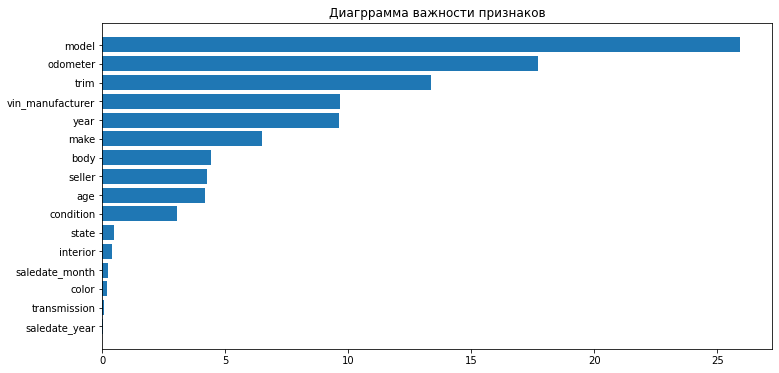

In [39]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X)[sorted_idx])
plt.title('Диагррамма важности признаков')
plt.show()

Согласно диаграмме важности признаков, полученной по результатам обучения модели, мы видим, что наибольшее влияние на качество оказыквает `model` - модель. Также большую важность имеют `odometer` - пробег в милях и `trim` - модификация, `vin_manufacturer` - место производства и `year` - год выпуска.

Такие признаки, как `saledate_year` - год продажи, `saledate_month` - месяц продажи и `transmission` - тип КПП не имеют практически никакого влияния. Однако, как показала практика, если убрать даные признаки из набора для обучения, показатели качества обучения модели немного упадут. Поэтому мы не можем считать такие признаки шумом и оставляем их в обучающем наборе.

### 7. Формирование и выгрузка предсказаний

Для того, чтобы обучение тестового датасета прошло корректно, добавим в него новые категориальные признаки, которые мы использовали ранее в обучении.

In [40]:
df_test['vin_manufacturer'] = df_test['vin'].str[0:3]
df_test['saledate_year'] = pd.DatetimeIndex(pd.to_datetime(df_test['saledate'].str[0:15], format='%a %b %d %Y')).year
df_test['saledate_month'] = pd.DatetimeIndex(pd.to_datetime(df_test['saledate'].str[0:15], format='%a %b %d %Y')).month
df_test['saledate_year'] = pd.DatetimeIndex(pd.to_datetime(df_test['saledate'].str[0:15], format='%a %b %d %Y')).year
df_test['age'] = df_test['saledate_year'] - df_test['year']

Также необходимо провести кодирование и масштабирование с помощью того же инструмента `.transform()`, а затем предсказать цену каждого автомобиля в тестовом датасете.

In [41]:
df_test_sc = enc.transform(df_test[X])
test_pool = Pool(df_test_sc)
predictions = model.predict(test_pool)

По условиям задачи на страницу соревнования `Kaggle` необходимо загрузить датасет, состоящий из двух колонок: `vin` и `sellingprice` (предсказанная стоимость), без индексов. Для этого сформируем датасет с нужными колонками.

In [42]:
df_test_fin = pd.DataFrame(df_test['vin'])
df_test_fin['sellingprice'] = pd.DataFrame(predictions)
df_test_fin

,vin,sellingprice
0,1g6dp567450124779,4667.582840
1,1gtw7fca7e1902207,22469.323143
2,jn8az1mw6dw303497,19372.659620
3,2g1wf5e34d1160703,9000.882464
4,1n6aa0ec3dn301209,22108.314437
...,...,...
110053,1j4aa2d17bl584330,17231.240171
110054,jthbf1d23e5007526,29009.335230
110055,1n4ba41e54c831950,4565.919425
110056,jn1az4eh3dm382431,18495.192152


Выгрузим полученные результаты без индексов в файл `submission.csv`.

In [43]:
df_test_fin.to_csv(r"submission.csv", index=False)

## Вывод

1. Мы загрузили данные для проекта определения стоимости авто при продаже и ознакомились с ними.
2. Мы избавились от пропусков, проверили значения в числовых признаках, а также на дубли. Нашли аномальные значения и избавились от них.
3. Разработали новые признаки, а также сгруппировали категориальные, используемые нами дажее в рамках экспериментов для выбора подходящих признаков для обучения.
4. Для данного проекта был выбран новый инструмент `CatBoost`, показывающий лучшие результаты по сравнению с ранее изученными. Наилучший показатель ключевой метрики качетва `MAPE` достиг `15.21%`, что позволило войти в `ТОП-5` данного соревнования.
5. Был проведен анализ важности признаков модели, наиблее важными стали `model` - модель, `odometer` - пробег в милях и `trim` - модификация.